In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
df_stroke = pd.read_csv("stroke_full.csv")
df_heart_disease = pd.read_csv("heart_disease_full.csv")
df_hypertension = pd.read_csv("hypertension_full.csv")

In [5]:
df_stroke

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.8,never smoked,1
2,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
3408,Female,80,1,0,Yes,Private,Urban,83.75,28.4,never smoked,0
3409,Female,81,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
3410,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
3411,Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [6]:
df_stroke['heart_risk'] = (df_stroke['hypertension'] | df_stroke['heart_disease']).astype(int)

Encoding categorical features.

In [7]:
# One-Hot Encoding for categorical features.
# One-Hot Encoding using pd.get_dummies.
df = pd.get_dummies(df_stroke, columns=['work_type', 'smoking_status', 'gender','ever_married', 'Residence_type'], drop_first=True)

# Check the transformed data
print(df.head())

   age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
0   67             0              1             228.69  36.6       1   
1   61             0              0             202.21  28.8       1   
2   80             0              1             105.92  32.5       1   
3   49             0              0             171.23  34.4       1   
4   79             1              0             174.12  24.0       1   

   heart_risk  work_type_Private  work_type_Self-employed  \
0           1               True                    False   
1           0              False                     True   
2           1               True                    False   
3           0               True                    False   
4           1              False                     True   

   smoking_status_formerly smoked  smoking_status_never smoked  \
0                            True                        False   
1                           False                         True   
2 

Standardize the numerical columns (age, avg_glucose_level, and bmi).

In [8]:
# Feature scaling on the numerical columns (age, avg_glucose_level, and bmi) using the StandardScaler from the sklearn.preprocessing module. 
# This is a preprocessing step to standardize the data so that each feature has a mean of 0 and a standard deviation of 1.

from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Scale numerical features: age, avg_glucose_level, bmi
df[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(df[['age', 'avg_glucose_level', 'bmi']])

# Check the scaled data
print(df[['age', 'avg_glucose_level', 'bmi']].head())

        age  avg_glucose_level       bmi
0  0.763532           2.312038  0.887420
1  0.343728           1.787070 -0.305926
2  1.673108          -0.121883  0.260149
3 -0.495881           1.172891  0.550835
4  1.603141           1.230185 -1.040292


In [9]:
df = df[['age', 'avg_glucose_level', 'heart_risk', 'stroke']]
df.head(3)

,age,avg_glucose_level,heart_risk,stroke
0,0.763532,2.312038,1,1
1,0.343728,1.787070,0,1
2,1.673108,-0.121883,1,1


Split the data into a training and testing set. 

In [10]:
from sklearn.model_selection import train_test_split

# set a seed for reproducibility
np.random.seed(123)

X_train, X_test, y_train, y_test = train_test_split(
    df.drop('stroke', axis=1), df["stroke"], train_size=0.75, shuffle=True, stratify=df["stroke"]
)

SMOTE

In [11]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Create an instance of SMOTE
smote = SMOTE()

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_smote))

Before SMOTE: Counter({0: 2374, 1: 185})
After SMOTE: Counter({0: 2374, 1: 2374})


Train XGBoost Model

In [12]:
import xgboost as xgb

# Initialize XGBoost classifier
model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',  # Evaluation metric for classification
    use_label_encoder=False,  # Avoid unnecessary warnings
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=5,  # Depth of trees
    subsample=0.8,  # Fraction of data to train each tree
    colsample_bytree=0.8,  # Fraction of features used for each tree
    random_state=42,
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
)

# Train model
model_xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = model_xgb.predict(X_test)
y_probs = model_xgb.predict_proba(X_test)[:, 1]  # Get probability for class 1 (stroke)



/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:37:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluate Model Performance

Accuracy: 0.7646

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.78      0.86       792
           1       0.17      0.56      0.26        62

    accuracy                           0.76       854
   macro avg       0.56      0.67      0.56       854
weighted avg       0.90      0.76      0.82       854



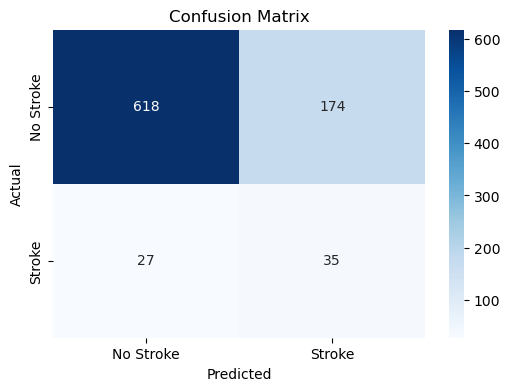

In [13]:

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {accuracy:.4f}')

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Display confusion matrix
#print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Stroke", "Stroke"], yticklabels=["No Stroke", "Stroke"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Feature Importance Analysis

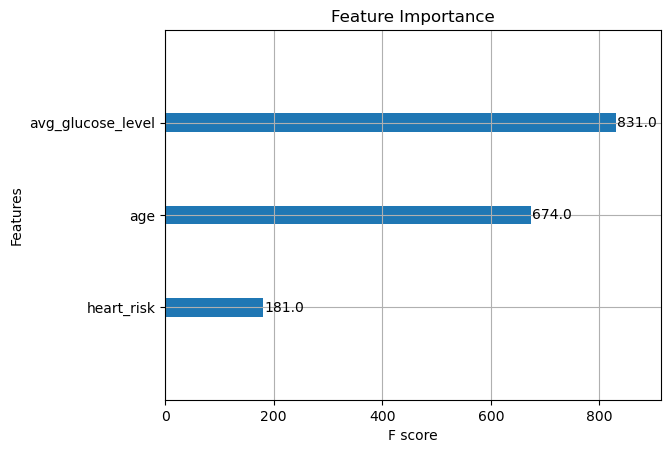

In [14]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance
xgb.plot_importance(model_xgb, importance_type='weight', title='Feature Importance')
plt.show()


Hyperparameter Tuning

In [15]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'min_child_weight': [3, 5, 7],
    'gamma': [0, 0.1, 0.5],
    'scale_pos_weight': [10, 15, 20]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)

# Fit model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Train model with best params
best_model_xgb = grid_search.best_estimator_


Fitting 3 folds for each of 2916 candidates, totalling 8748 fits


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:37:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:37:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:37:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:37:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are no

Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500, 'scale_pos_weight': 10, 'subsample': 0.6}


In [16]:
print("Best Parameters Found:", grid_search.best_params_)


Best Parameters Found: {'colsample_bytree': 0.5, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500, 'scale_pos_weight': 10, 'subsample': 0.6}


In [17]:
y_pred_xgb = best_model_xgb.predict(X_test)


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.77      0.86       792
           1       0.20      0.73      0.31        62

    accuracy                           0.77       854
   macro avg       0.59      0.75      0.59       854
weighted avg       0.92      0.77      0.82       854



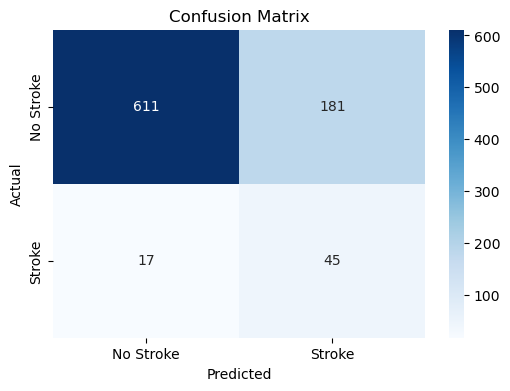

In [18]:
#from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Stroke", "Stroke"], yticklabels=["No Stroke", "Stroke"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

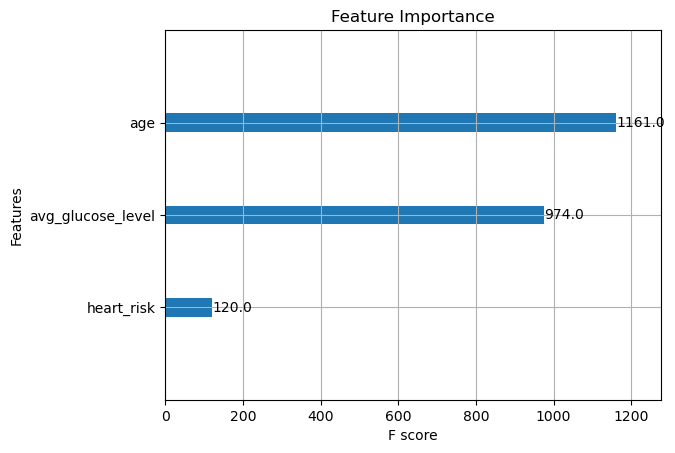

In [19]:
# Plot feature importance
xgb.plot_importance(best_model_xgb, importance_type='weight', title='Feature Importance')
plt.show()
